In [2]:
import sys
sys.path.insert(0,'..')

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from src.models.model_diff_modular import ModularDiffModel

In [ ]:
output_folder = "charts"

In [4]:
folder = "/share/home/lukash/checkpoints_bert_L4/seed{}"
experiment_name_seed0 = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular.pt"
experiment_name = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular-sparse_task.pt"

In [5]:
# exp_idx = 1

# exp_name = experiment_name_seed0 if exp_idx==0 else experiment_name
# filepath = os.path.join(folder.format(exp_idx), exp_name)
# model = ModularDiffModel.load_checkpoint(filepath)

In [6]:
d = {}
for exp_idx in range(5):
    exp_name = experiment_name_seed0 if exp_idx==0 else experiment_name
    filepath = os.path.join(folder.format(exp_idx), exp_name)
    model = ModularDiffModel.load_checkpoint(filepath)

    for m_name, m in model.get_encoder_base_modules(return_names=True):
        for n, par_list in list(m.parametrizations.items()):
            k = m_name + "." + n
            if k not in d:
                d[k] = [[],[]]
            for i in range(2):
                p = par_list[i].mask.data
                d[k][i].append(p)

d = {k:[torch.stack(x) for x in v] for k,v in d.items()}

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [7]:
parameter_sizes = {k:v[0].numel() for k,v in d.items()}
parameter_sizes_emb = {k:v for k,v in parameter_sizes.items() if k[:9] == "embedding"}
parameter_sizes_layer = {k[16:]:v for k,v in parameter_sizes.items() if k[:15] == "encoder.layer.0"}

In [8]:
parameter_sizes_sorted = dict(sorted({**parameter_sizes_emb, **parameter_sizes_layer}.items(), key=lambda item: item[1], reverse=True))
parameter_sizes_sorted

{'embeddings.word_embeddings.weight': 39068160,
 'intermediate.dense.weight': 1310720,
 'output.dense.weight': 1310720,
 'embeddings.position_embeddings.weight': 655360,
 'attention.self.query.weight': 327680,
 'attention.self.key.weight': 327680,
 'attention.self.value.weight': 327680,
 'attention.output.dense.weight': 327680,
 'intermediate.dense.bias': 5120,
 'embeddings.token_type_embeddings.weight': 2560,
 'embeddings.LayerNorm.weight': 1280,
 'embeddings.LayerNorm.bias': 1280,
 'attention.self.query.bias': 1280,
 'attention.self.key.bias': 1280,
 'attention.self.value.bias': 1280,
 'attention.output.dense.bias': 1280,
 'attention.output.LayerNorm.weight': 1280,
 'attention.output.LayerNorm.bias': 1280,
 'output.dense.bias': 1280,
 'output.LayerNorm.weight': 1280,
 'output.LayerNorm.bias': 1280}

In [9]:
def analyse_fn(t):
    t_ = t.sum(0)
    total = (t_>0).sum()
    return [((t_==val).sum()/total).item() for val in range(1,6)]

shares_dict = {k:[analyse_fn(x) for x in v] for k,v in d.items() if k[:6]!="pooler"}

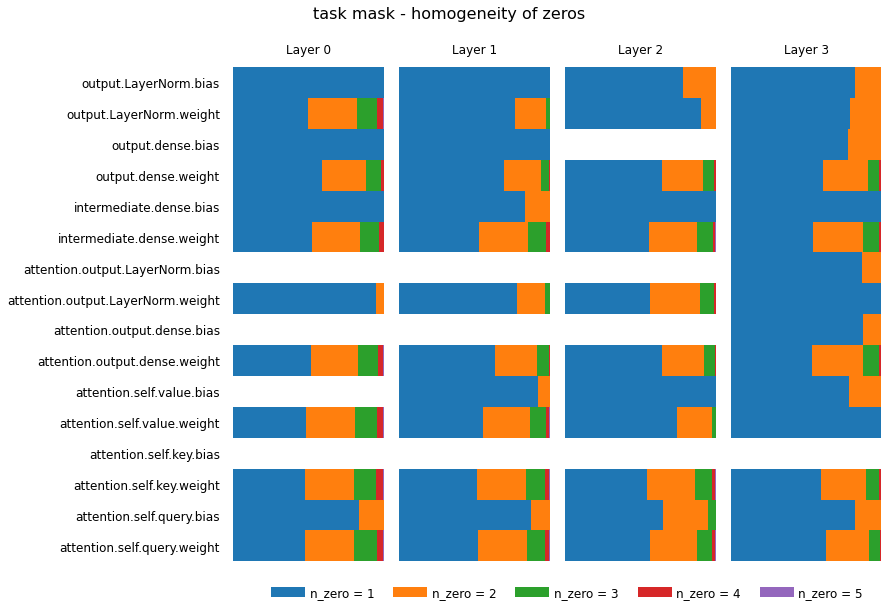

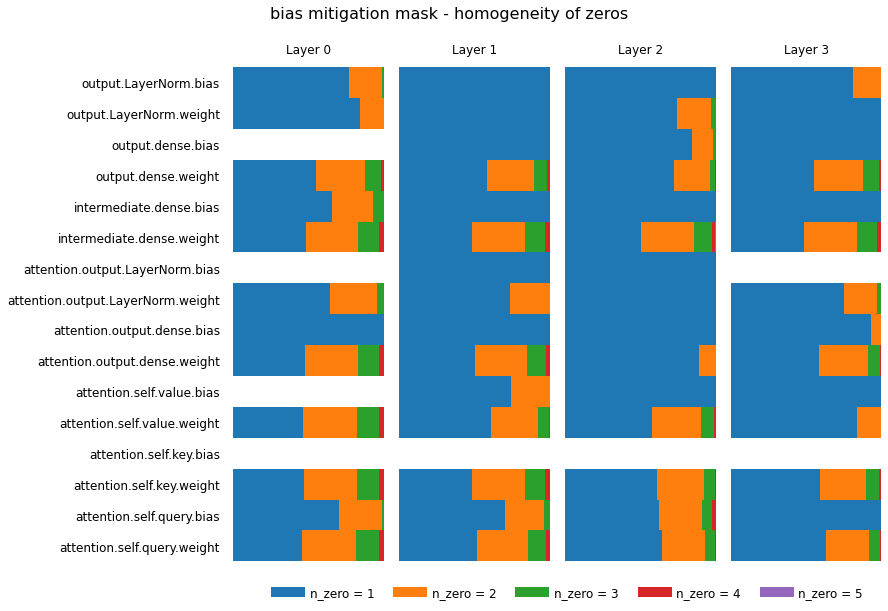

In [10]:
for mask_idx, mask_name in enumerate(["task mask", "bias mitigation mask"]):

    shares_dict_layer_x = {k:v[mask_idx] for k,v in shares_dict.items() if k[:14]=="encoder.layer."}

    y_coord = np.arange(len(shares_dict_layer_x) // 4)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    title_fontsize = 16
    text_fontsize = 12
    fig, axs = plt.subplots(1,4, figsize=(15, 10))
    for layer_idx, ax in enumerate(axs):
        d = {k[16:]:v for k,v in shares_dict_layer_x.items() if int(k[14])==layer_idx}

        start = 0
        for i in range(5):
            v = [x[i] for x in d.values()]
            v = np.nan_to_num(np.array(v))
            ax.barh(y_coord, v, height=1, left=start, color=colors[i])
            if layer_idx==0:
                ax.set_yticks(y_coord, d.keys(), fontsize=text_fontsize)
                ax.tick_params(axis="y", left=False, pad=10)
            else:
                ax.set_yticks([])
            ax.set_xticks([])
            ax.set_title(f"Layer {layer_idx}", fontsize=text_fontsize, y=.97)
            start += v
    sns.despine(left=True, bottom=True, right=True)

    custom_lines = [Line2D([0], [0], color=c, lw=10) for c in colors]
    plt.legend(custom_lines, [f"n_zero = {i}" for i in range(1,6)], ncol=5, bbox_to_anchor=(0.95, 0.02), frameon=False, fontsize=text_fontsize)

    plt.suptitle(f"{mask_name} - homogeneity of zeros", y=.93, fontsize=title_fontsize)
    plt.subplots_adjust(left=0.3, wspace=0.1)
    plt.savefig(os.path.join(output_folder, f"{mask_name.replace(' ', '_')}_homogeneity.png"))
    plt.show()